# Project 2 iceberg vs ship

For this project, the input data is 75 x 75 figures that contain iceberg or ship. It would be interesting to show this figures. So the first part is to show some figures. The data is in json files, the function "read_josn" from pandas can be used to draw the figures.

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# read the train data into dat
dat = pd.read_json("/home/kaiwang/Desktop/project2/train.json")

In [61]:
# in order to draw the iceberg and ship, get the index of icebergs and ships
idx_ship = np.where(dat['is_iceberg'] == 0)
idx_iceb = np.where(dat['is_iceberg'] == 1)

In [62]:
# define the plot function to draw the figures
def fig_plot(band, idx, label):
    plt.figure(figsize=(10,10))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.xlabel((label))
        plt.imshow(np.reshape(dat[band][idx[0][i]],(75,75)))
    plt.show()

The figures are come from two bands, so both band_1 and band_2 are displayed.

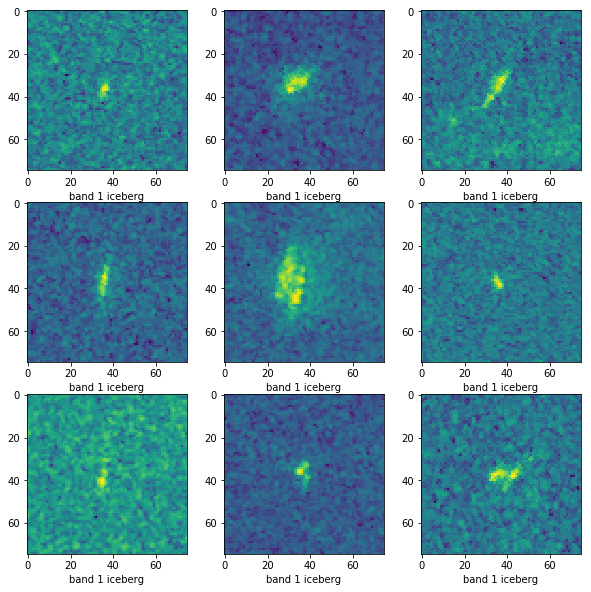

In [63]:
#band_1 iceberg example
fig_plot('band_1', idx_iceb,'band 1 iceberg')

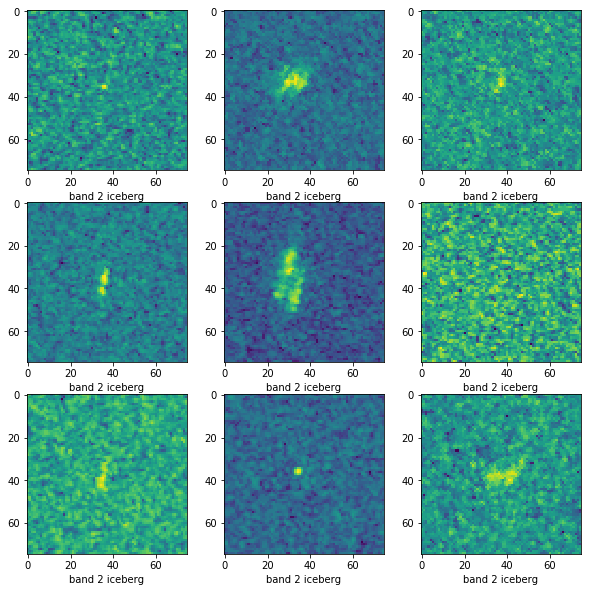

In [64]:
#band_2 iceberg example
fig_plot('band_2', idx_iceb,'band 2 iceberg')

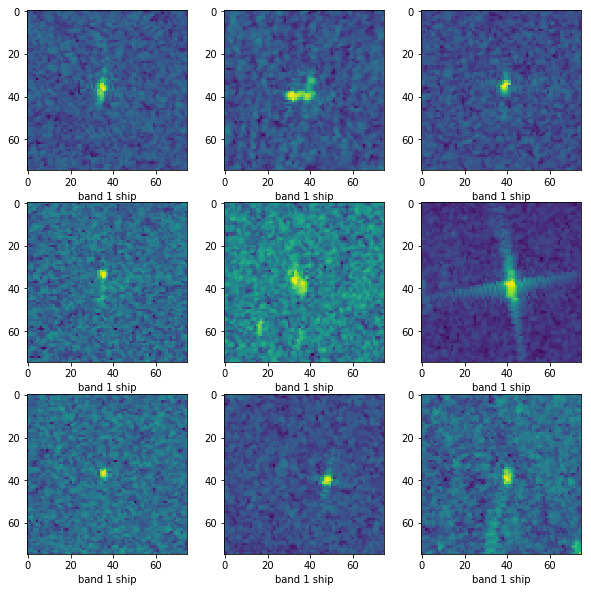

In [65]:
#band_1 ship examples
fig_plot('band_1', idx_ship,'band 1 ship')

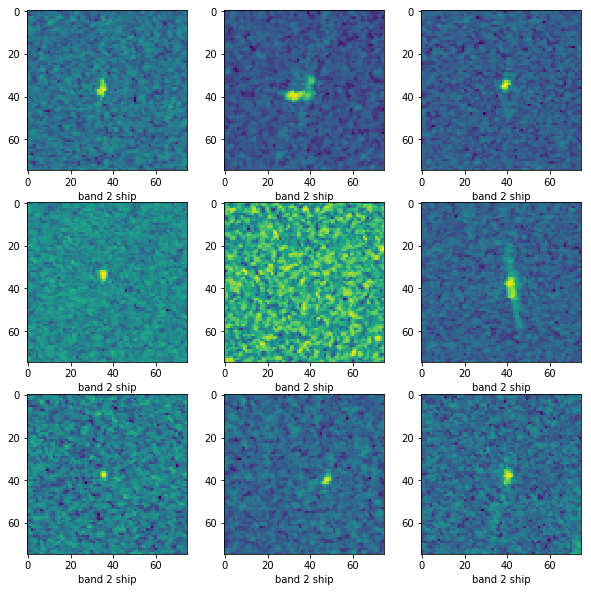

In [66]:
#band_2 ship examples
fig_plot('band_2', idx_ship,'band 2 ship')

It is very difficult to tell one figure is ship or iceberg without the index. In order to make a good prediction just based on these figures, CNN network was used for this project.
Firstly, the data format was displayed in following table. Each figure in training data set are represented as five columns, band_1, band_2, id, inc_angle, and is_iceberg. "1" in is_iceberg col means this figure is a iceberg and "0" means this figure is a iceberg.

In [3]:
dat.sample(3)

,band_1,band_2,id,inc_angle,is_iceberg
53,"[-18.96467, -21.967827, -21.071625, -20.737555...","[-32.944069, -29.647911, -28.778641, -30.11762...",6c905a48,42.5742,1
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
1281,"[-14.896353, -17.167608, -19.834463, -19.83446...","[-27.658453, -26.130756, -25.076702, -25.07670...",750122bb,34.9452,0


In order to train a CNN network, the data need to be transfered into a matrix. Following code transfers each row into a 75 x 75 matrix for training. "band_1" and "band_2" are stacked together as a 75 x 75 x 2 matrix.

In [4]:
#transfer the json data into matrix for training CNN
m_dat = dat.apply(lambda c_row: [np.stack([c_row['band_1'],c_row['band_2']], -1).reshape((75,75,2))],1)
m_dat = np.stack(m_dat).squeeze()
print(m_dat.shape)

(1604, 75, 75, 2)


The CNN network was implemented by using Keras. First to import necessary packages.  

In [4]:
from sklearn.model_selection import KFold
from keras.utils.np_utils import to_categorical
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, Activation, Dropout, MaxPooling2D, GlobalMaxPooling2D, Dense
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


KFold was used for cross validation during the training process. The training data set split into 5 pieces, four of them used for training and the last one part was used for testing.

In [5]:
kf = KFold(n_splits=5, shuffle = True, random_state=1)
Y = np_utils.to_categorical(dat['is_iceberg'],2)

The model is defined as following, two Conv2D layer was applied before dense layer. ReLU was used as astivation functions. Dropout layers was also applied for preventing overfit. An early stop was applied if the accuracy does not improve after 10 iterations.

In [ ]:
#train the model

for train_index, test_index in kf.split(m_dat):
    X_train = m_dat[train_index]
    Y_train = Y[train_index]
    X_test  = m_dat[test_index]
    Y_test  = Y[test_index]
    
    model = Sequential()
    
    model.add(BatchNormalization(input_shape = (75, 75, 2)))
    model.add(Conv2D(32, kernel_size = (3,3)))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(64, kernel_size = (3,3)))
    model.add(MaxPooling2D((2,2)))
    model.add(GlobalMaxPooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2))
    model.add(Activation('softmax'))
    model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    callbacks = [EarlyStopping(monitor='val_loss',patience=10,verbose=0)]
    model.fit(x=X_train,y=Y_train, validation_data=(X_test,Y_test), batch_size=32, epochs=150, callbacks=callbacks,verbose=1)


Then use this model to predict the test data set. Do the same transformation to the test data that each figure is represanted as a 75 x 75 x 2 matirx.

In [91]:
#make prediction on test data
test = pd.read_json("/home/kaiwang/Desktop/project2/test.json")
m_test = test.apply(lambda c_row: [np.stack([c_row['band_1'],c_row['band_2']], -1).reshape((75,75,2))],1)
m_test = np.stack(m_test).squeeze()

In [92]:
test_pre = model.predict(m_test)

In [93]:
out = test[['id']].copy()
out['is_iceberg'] = test_pre[:,1]
out.to_csv('/home/kaiwang/Desktop/project2/sub.csv',index = False)
out.sample(3)

,id,is_iceberg
8231,7d52d713,0.028557
630,7a8521e2,0.000013
4563,215e6c06,0.831938


After submission, the score is 0.1974. It is pretty good. After this,  I did some feature normalization on the training data. A third layer matrix was calculated  by “band_3 = band_1 / band_2” and added to the feature space.

In [96]:
test.to_pickle('/home/kaiwang/Desktop/project2/test.pkl')

In [6]:
def normlization(dat):
    out = []
    for i, row in dat.iterrows():
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 / band_2
        band_1_norm = (band_1 - band_1.mean()) / (band_1.max() - band_1.min())
        band_2_norm = (band_2 - band_2.mean()) / (band_2.max() - band_2.min())
        band_3_norm = (band_3 - band_3.mean()) / (band_3.max() - band_3.min())
        out.append(np.dstack((band_1_norm, band_2_norm, band_3_norm)))
    return np.array(out)        

Now each figure is represanted by 75 x 75 x 3 matirx.

In [9]:
m_train = normlization(dat)
print (m_train.shape)

(1604, 75, 75, 3)


In [10]:
kf = KFold(n_splits=5, shuffle = True, random_state=1)
Y = np_utils.to_categorical(dat['is_iceberg'],2)
print(Y.shape)

(1604, 2)


Same CNN network expect the input shape is 75 x 75 x 3 was used for training. 

In [ ]:
for train_index, test_index in kf.split(m_train):
    X_train = m_train[train_index]
    Y_train = Y[train_index]
    X_test  = m_train[test_index]
    Y_test  = Y[test_index]
    
    model = Sequential()
    
    model.add(BatchNormalization(input_shape = (75, 75, 3)))
    model.add(Conv2D(32, kernel_size = (3,3)))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(64, kernel_size = (3,3)))
    model.add(MaxPooling2D((2,2)))
    model.add(GlobalMaxPooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2))
    model.add(Activation('softmax'))
    model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    callbacks = [EarlyStopping(monitor='val_loss',patience=10,verbose=0)]
    model.fit(x=X_train,y=Y_train, validation_data=(X_test,Y_test), batch_size=32, epochs=150, callbacks=callbacks,verbose=1)


In [13]:
test = pd.read_pickle('/home/kaiwang/Desktop/project2/test.pkl')

Before prediction, do the same normlization to the test data set. Now the test data is also represanted by 75 x 75 x 3 matirx.

In [14]:
m_test = normlization(test)
print (m_test.shape)

(8424, 75, 75, 3)


In [15]:
test_pre = model.predict(m_test)
out = test[['id']].copy()
out['is_iceberg'] = test_pre[:,1]
out.to_csv('/home/kaiwang/Desktop/project2/sub1.csv',index = False)
out.sample(3)

,id,is_iceberg
3475,be0ec8fe,0.003039
3879,31db6283,0.977780
3754,5ecfcf04,0.895134


After the submission, the socre is 0.2394, it is increased which is really bad. Based on this data, the netwrok was modified with adding two conv2D layers with more kernels. 

In [ ]:
for train_index, test_index in kf.split(m_train):
    X_train = m_train[train_index]
    Y_train = Y[train_index]
    X_test  = m_train[test_index]
    Y_test  = Y[test_index]
    
    model = Sequential()
    
    model.add(BatchNormalization(input_shape = (75, 75, 3)))
    model.add(Conv2D(32, kernel_size = (3,3)))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(64, kernel_size = (3,3)))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(128, kernel_size = (3,3)))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(64, kernel_size = (3,3)))
    model.add(MaxPooling2D((2,2)))
    model.add(GlobalMaxPooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2))
    model.add(Activation('softmax'))
    model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    callbacks = [EarlyStopping(monitor='val_loss',patience=10,verbose=0)]
    model.fit(x=X_train,y=Y_train, validation_data=(X_test,Y_test), batch_size=32, epochs=150, callbacks=callbacks,verbose=1)


In [8]:
test = pd.read_pickle('/home/kaiwang/Desktop/project2/test.pkl')

In [14]:
m_test = normlization(test)
print (m_test.shape)

(8424, 75, 75, 3)


In [13]:
test_pre = model.predict(m_test)
out = test[['id']].copy()
out['is_iceberg'] = test_pre[:,1]
out.to_csv('/home/kaiwang/Desktop/project2/sub1.csv',index = False)
out.sample(3)

,id,is_iceberg
7929,fdf92ff1,1.000000
5408,f21e5bb1,0.000003
1602,f90b1c41,0.001305


After the submission, the score keeps increase to 0.4839. :-(
I don't know why this happens. Someone toal me that maybe the reason is that the train data set is too small to get a robust model. Then I did some flip to increase the train data set.

In [7]:
def augment(images):
    image_mirror_lr = []
    image_mirror_ud = []
    for i in range(0,images.shape[0]):
        band_1 = images[i,:,:,0]
        band_2 = images[i,:,:,1]
        band_3 = images[i,:,:,2]
            
        # mirror left-right
        band_1_mirror_lr = np.flip(band_1, 0)
        band_2_mirror_lr = np.flip(band_2, 0)
        band_3_mirror_lr = np.flip(band_3, 0)
        image_mirror_lr.append(np.dstack((band_1_mirror_lr, band_2_mirror_lr, band_3_mirror_lr)))
        
        # mirror up-down
        band_1_mirror_ud = np.flip(band_1, 1)
        band_2_mirror_ud = np.flip(band_2, 1)
        band_3_mirror_ud = np.flip(band_3, 1)
        image_mirror_ud.append(np.dstack((band_1_mirror_ud, band_2_mirror_ud, band_3_mirror_ud)))
        
    mirrorlr = np.array(image_mirror_lr)
    mirrorud = np.array(image_mirror_ud)
    images = np.concatenate((images, mirrorlr, mirrorud))
    return images

After the augmentation, the training data set contains 4812 figures.

In [8]:
m_train = normlization(dat)
print (m_train.shape)
m_train = augment(m_train)
print (m_train.shape)

(1604, 75, 75, 3)
(4812, 75, 75, 3)


The label also need to be 4812.

In [11]:
print(Y.shape)
Y = np.concatenate((Y, Y, Y))
print(Y.shape)

(1604, 2)
(4812, 2)


Then, I used the first simple CNN to train the new data.

In [ ]:
kf = KFold(n_splits=5, shuffle = True, random_state=1)
for train_index, test_index in kf.split(m_train):
    X_train = m_train[train_index]
    Y_train = Y[train_index]
    X_test  = m_train[test_index]
    Y_test  = Y[test_index]
    
    model = Sequential()
    
    model.add(BatchNormalization(input_shape = (75, 75, 3)))
    model.add(Conv2D(32, kernel_size = (3,3)))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(64, kernel_size = (3,3)))
    model.add(MaxPooling2D((2,2)))
    model.add(GlobalMaxPooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2))
    model.add(Activation('softmax'))
    model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    callbacks = [EarlyStopping(monitor='val_loss',patience=10,verbose=0)]
    model.fit(x=X_train,y=Y_train, validation_data=(X_test,Y_test), batch_size=32, epochs=150, callbacks=callbacks,verbose=1)


In [22]:
test_pre = model.predict(m_test)
out = test[['id']].copy()
out['is_iceberg'] = test_pre[:,1]
out.to_csv('/home/kaiwang/Desktop/project2/sub.csv',index = False)
out.sample(3)

,id,is_iceberg
1007,44556da6,0.808470
7472,0755e09a,0.234935
4921,6eb6db7a,0.237412


After the submission, the score is 0.2420. It is still higher than the first attemption. Then I added a conv2D layer to model to train the data and remove the batchnorm layer.

In [ ]:
kf = KFold(n_splits=5, shuffle = True, random_state=1)
for train_index, test_index in kf.split(m_train):
    X_train = m_train[train_index]
    Y_train = Y[train_index]
    X_test  = m_train[test_index]
    Y_test  = Y[test_index]
    
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size = (3,3), input_shape=(75, 75, 3)))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(64, kernel_size = (3,3)))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(64, kernel_size = (3,3)))
    model.add(MaxPooling2D((2,2)))
    model.add(GlobalMaxPooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2))
    model.add(Activation('softmax'))
    model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    callbacks = [EarlyStopping(monitor='val_loss',patience=10,verbose=0)]
    model.fit(x=X_train,y=Y_train, validation_data=(X_test,Y_test), batch_size=32, epochs=150, callbacks=callbacks,verbose=1)


In [9]:
test_pre = model.predict(m_test)
out = test[['id']].copy()
out['is_iceberg'] = test_pre[:,1]
out.to_csv('/home/kaiwang/Desktop/project2/sub1.csv',index = False)
out.sample(3)

,id,is_iceberg
2142,b64c8598,5.665052e-03
565,a8b8c20b,8.179715e-01
5501,8c41f5df,1.238372e-09


After the submission, the socre is 0.2110. 

THe score is still not ideal. So I want to train the data with a bigger network. But my laptop cannot handle a bigger one (5 conv2d layer could kill my laptop). Then I tried remove the band_3 and use the first model with augmented data. 

In [1]:
def augment(images):
    image_mirror_lr = []
    image_mirror_ud = []
    for i in range(0,images.shape[0]):
        band_1 = images[i,:,:,0]
        band_2 = images[i,:,:,1]
        
            
        # mirror left-right
        band_1_mirror_lr = np.flip(band_1, 0)
        band_2_mirror_lr = np.flip(band_2, 0)
        
        image_mirror_lr.append(np.dstack((band_1_mirror_lr, band_2_mirror_lr)))
        
        # mirror up-down
        band_1_mirror_ud = np.flip(band_1, 1)
        band_2_mirror_ud = np.flip(band_2, 1)
        
        image_mirror_ud.append(np.dstack((band_1_mirror_ud, band_2_mirror_ud)))
        
    mirrorlr = np.array(image_mirror_lr)
    mirrorud = np.array(image_mirror_ud)
    images = np.concatenate((images, mirrorlr, mirrorud))
    return images

def normlization(dat):
    out = []
    for i, row in dat.iterrows():
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
    
        band_1_norm = (band_1 - band_1.mean()) / (band_1.max() - band_1.min())
        band_2_norm = (band_2 - band_2.mean()) / (band_2.max() - band_2.min())
   
        out.append(np.dstack((band_1_norm, band_2_norm)))
    return np.array(out)     

In [6]:
m_train = normlization(dat)
print (m_train.shape)
m_train = augment(m_train)
print (m_train.shape)
print(Y.shape)
Y = np.concatenate((Y, Y, Y))
print(Y.shape)m_test = normlization(test)
print (m_test.shape)

(1604, 75, 75, 2)
(4812, 75, 75, 2)
(1604, 2)
(4812, 2)


In [ ]:
for train_index, test_index in kf.split(m_train):
    X_train = m_train[train_index]
    Y_train = Y[train_index]
    X_test  = m_train[test_index]
    Y_test  = Y[test_index]
    
    model = Sequential()
    
    model.add(BatchNormalization(input_shape = (75, 75, 2)))
    model.add(Conv2D(32, kernel_size = (3,3)))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(64, kernel_size = (3,3)))
    model.add(MaxPooling2D((2,2)))
    model.add(GlobalMaxPooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2))
    model.add(Activation('softmax'))
    model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    callbacks = [EarlyStopping(monitor='val_loss',patience=10,verbose=0)]
    model.fit(x=X_train,y=Y_train, validation_data=(X_test,Y_test), batch_size=32, epochs=150, callbacks=callbacks,verbose=1)


In [9]:
m_test = normlization(test)
print (m_test.shape)

(8424, 75, 75, 2)


In [10]:
test_pre = model.predict(m_test)
out = test[['id']].copy()
out['is_iceberg'] = test_pre[:,1]
out.to_csv('/home/kaiwang/Desktop/project2/sub2.csv',index = False)
out.sample(3)

,id,is_iceberg
4254,81b69ec9,0.981784
7216,55a99353,0.000183
1215,ade738c7,0.004324


I haven't upload this result since I need to wait 24 hours to upload. Basically, this is all for the project 2.